In [1]:
%cd ..
import jax.numpy as jnp
import matplotlib.pyplot as plt
from stencilnet.finite_volume import generate_rectilinear_mesh, u0, dynamics
import stencilnet.ode as ode

%cd examples/

/u/jp7427/Desktop/StencilNet
/u/jp7427/Desktop/StencilNet/examples


/u/jp7427/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# smooth advection problem parameters
T = 1
v = (2, 1)
u0_func = lambda x, y: u0(x, y, "sinus")
cfl = 0.5

# loop parameters
ns = [16, 32, 64]
ps = [0, 1, 2, 3]
steps = [ode.euler_step, ode.ssprk2_step, ode.ssprk3_step, ode.rk4_step]

I0000 00:00:1706121916.999910  127204 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


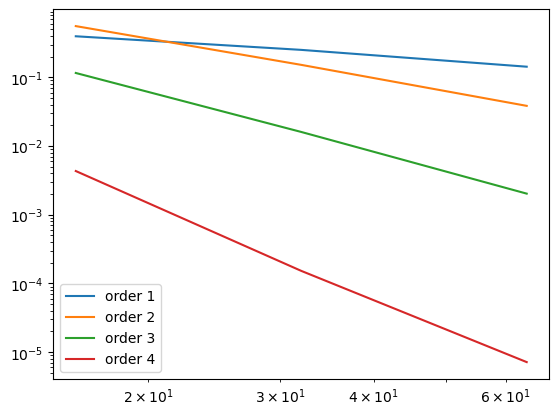

In [3]:
# loop through ps and ns
for p, step in zip(ps, steps):
    errs = []
    for n in ns:
        x, y = generate_rectilinear_mesh((0, 1), (0, 1), n)
        u_init = u0_func(x, y)
        h = (1 / n, 1 / n)
        dt = cfl / (v[0] / h[0] + v[1] / h[1])
        n_steps = int(jnp.ceil(T // dt))

        # execute solver
        U = ode.integrator(
            f=lambda u: dynamics(u, v=v, p=p, h=h),
            step=step,
            u_init=u_init,
            n_steps=n_steps,
            T=T,
        )

        # compute l1 norm of periodic error
        errs.append(jnp.sum(jnp.abs(U[-1] - U[0])) / n**2)
    # plot
    plt.plot(ns, errs, label=f"order {p + 1}")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()